# Dialect Classification

In [62]:
import numpy as np
import pandas as pd
import IPython.display as ipd
import scipy.io.wavfile as wav
from scipy.fftpack import dct
from zipfile import ZipFile
import matplotlib.pyplot as plt
from scipy.stats import skew
import os,glob
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

#### Initializing essential variables

In [ ]:
# Setting up different variables
framelength = 0.025  #each frame is of size 25 milliseconds
frameoverlap = 0.015  #15 milliseconds of overlap between two frames
nfft = 512   #n for calculation of n-point fft
num_fbanks = 40  #number of filter banks
num_ceps = 20  #number of mel coefficients for each frame
dialects = [1,2,3,4,5,6,7,8,9]  #labels coreesponding to the 9 dialects
dataset_path = "dataset/IDR"  #location of the dataset

#### The function below returns a dataframe containing all file paths and their corresponding label

In [63]:
def generate_path(base_path):
    temp = []
    for types in dialects: 
        df = pd.DataFrame()
        base_dir = base_path + str(types)
        files = glob.glob(base_dir+'/*.wav')
        y = [types]*len(files)
        df["FILE"] = files
        df["OUTPUT"] = y
        temp.append(df)
    return pd.concat(temp).reset_index(drop=True)

#### The functions below are used in the computation of the MFC Coefficients

In [64]:
#the function takes in an array(audio file) and generates frames of specified size
def generate_audio_frames(fs,audio,frameSize,frameOverlap):
    frameLen, frameLap = int(round(fs*frameSize)), int(round(fs*frameOverlap))
    audioLen = len(audio)
    paddingLen = frameLap - (audioLen - frameLen) % frameLap #making number of frames even
    paddedAudio = np.concatenate((audio, np.zeros(paddingLen)), axis = 0)
    audioLen = len(paddedAudio)
    numberOfFrames = int(np.floor((audioLen - frameLen)/frameLap) + 1)
    indices = np.tile(np.arange(0, frameLen), (numberOfFrames, 1)) + np.tile((np.arange(0, numberOfFrames*frameLap, frameLap)), (frameLen, 1)).T
    frames = paddedAudio[indices]
    return frames, frameLen

In [65]:
#applies hamming window on the frames
def apply_hamming(frames,frameLen):
    frames = frames * np.hamming(frameLen)
    return frames

In [66]:
#computes the power spectrum of the input frame, also takes in nfft as parameter
def power_spectrum(frames, nfft):
    mag_frames = np.absolute(np.fft.rfft(frames, nfft))  # Magnitude of the FFT
    pow_frames = np.square(mag_frames)/nfft  # Power Spectrum
    return pow_frames

In [90]:
#given the specifications of filter banks, returns the filter banks
def generate_filter_bank(fs,num_banks,nfft):
    
    #conversion from normal scale to mel scale and vice versa
    hz_to_mel = lambda x: (2595 * np.log10(1 + (x / 2) / 700))
    mel_to_hz = lambda x: (700*(np.power(10, x/2595) - 1))
    
    lower_mel = 0
    upper_mel = hz_to_mel(fs)
    mel_points = np.linspace(lower_mel, upper_mel, num_banks + 2)
    hz_points = mel_to_hz(mel_points)
    bins = np.floor((nfft + 1) * hz_points/fs)
    
    fbank = np.zeros((num_banks, int(np.floor(nfft/2 + 1))))
    for m in range(1, num_banks + 1):
        left = int(bins[m - 1])
        center = int(bins[m])
        right = int(bins[m + 1])
        for k in range(left, center):
            fbank[m - 1, k] = (k - bins[m - 1])/(bins[m] - bins[m - 1])
        for k in range(center, right):
            fbank[m - 1, k] = (bins[m + 1] - k)/(bins[m + 1] - bins[m])
    return fbank

In [68]:
#takes the power spectrum and filter banks as inputs and applies the filter banks to 
def apply_filter_banks(power_frames,fbank):
    filter_banks = np.dot(power_frames, fbank.T)
    #for numerical stability
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks) 
    filter_banks = 20*np.log10(filter_banks)
    return filter_banks

In [69]:
#performs a direct cosine transform on the input
def generate_mfcc(filterBanks,num_ceps):
    mfcc = dct(filterBanks, type = 2, axis = 1, norm = 'ortho')[:, 1:(num_ceps + 1)]
    return mfcc  

#### The function below returns a dataframe containing all file paths and their corresponding label

In [70]:
#copmutation of the mfcc of an audio involves six steps. Each function above coreesponds to one of the step.
#This function puts everything together and computes the mel coefficients of the audio signal
def audio_feature_extraction(audio_path,frameLen,frameOverlap,nfft,num_fbanks,num_ceps):
    fs, audio = wav.read(audio_path)
    frm,frmlen = generate_audio_frames(fs,audio,frameLen,frameOverlap)
    frm = apply_hamming(frm,frmlen)
    pow_frm = power_spectrum(frm,nfft)
    fbank = generate_filter_bank(fs,num_fbanks,nfft)
    filter_banks = apply_filter_banks(pow_frm,fbank)
    mfcc = generate_mfcc(filter_banks,num_ceps)
    return mfcc

#### Testing all the functions

In [72]:
dataset = generate_path(dataset_path)
dataset.tail()

,FILE,OUTPUT
598,dataset/IDR9/18.wav,9
599,dataset/IDR9/59.wav,9
600,dataset/IDR9/17.wav,9
601,dataset/IDR9/35.wav,9
602,dataset/IDR9/61.wav,9


In [73]:
num = 0
test = dataset["FILE"][num]
mfcc = audio_feature_extraction(test,framelength,frameoverlap,nfft,num_fbanks,num_ceps)

In [74]:
print(len(mfcc[0]))
dataset.shape

20


(603, 2)

#### The features dictionary contains all the features that we are computing from the mel coefficients

In [75]:
features = {
    "mean" : lambda x: np.mean(x,axis=0),
    "min" : lambda x: np.min(x,axis=0),
    "max" : lambda x: np.max(x,axis=0),
    "std_dev" : lambda x: np.std(x,axis=0),
    "median" : lambda x: np.median(x,axis=0)
}

#### The function below takes in a dataframe containing all file paths, computes alll the features specified in the features dictionary and returns a dataframe with all the computed features as columns

In [76]:
def generate_model_data(df,size=100):
    df = df.sample(frac=1).reset_index(drop=True)
    col = []
    y = []
    for key in features.keys():
        for i in range(1,num_ceps+1):
            col.append(key + str(i))
    rows = []
    for index, row in df.iterrows():
        if(index<size):
            temp = []
            y.append(row["OUTPUT"])
            path = row["FILE"]
            mfcc = audio_feature_extraction(path,framelength,frameoverlap,nfft,num_fbanks,num_ceps)
            for key in features.keys():
                temp.append(features[key](mfcc))
            rows.append(np.concatenate(temp))
        else:
            break
    feat = pd.DataFrame(rows)
    feat.columns = col
    feat["OUTPUT"] = y
    return feat

In [77]:
df = generate_model_data(dataset,602)

In [91]:
# 20 mfcc, 5 features for each feature => 100 columns + 1 output column
# 602 rows, each coreesponding to the audio samples
df.shape

(602, 101)

In [79]:
df.head(10)

,mean1,mean2,mean3,mean4,mean5,mean6,mean7,mean8,mean9,mean10,...,median12,median13,median14,median15,median16,median17,median18,median19,median20,OUTPUT
0,89.313323,14.612992,11.666629,-7.764394,-9.987186,-16.580497,-4.841163,-17.398501,-8.998086,3.964894,...,-8.635183,-8.498111,-10.567728,3.012781,0.388406,1.834255,-0.119938,2.989324,0.123489,3
1,88.041630,25.959772,4.988979,-8.332002,-13.384706,-7.125815,-3.545288,-0.123900,-9.479674,-4.940539,...,-2.623595,-0.416227,-3.090419,0.752596,-2.995165,1.311139,0.539260,0.247904,0.464574,7
2,87.911011,23.997047,19.505510,-3.202250,-0.282769,-8.822193,-5.779405,-5.916174,4.910173,-14.182814,...,-2.543394,-7.312992,-7.072617,-1.119527,-7.283901,1.536644,1.687218,2.312024,4.626798,5
3,69.327544,6.834665,20.984941,-12.514677,-10.709779,-11.914305,-2.348279,-5.890222,-6.451366,-4.724442,...,-3.608284,-6.235556,-9.213513,-0.878993,1.333194,-0.089229,1.769185,3.531212,1.376352,4
4,120.582644,44.508502,25.860543,-2.352005,-3.698330,-16.828993,-5.423935,-0.298286,-8.540664,0.696400,...,-9.444540,-8.458205,-5.840018,-1.634109,-0.819113,4.721761,0.509679,3.569527,2.908762,8
5,79.225491,18.130463,11.721813,-11.794390,-10.605181,-16.687883,-3.946916,-14.901932,-11.383001,3.645581,...,-8.518808,-7.610431,-9.053364,4.591127,1.589165,4.098517,0.582419,4.745498,0.724061,3
6,77.969959,-6.702051,28.526309,-6.331461,-8.470547,-21.751926,-6.025183,-7.629102,-6.326657,-2.053680,...,-3.021405,3.246912,-11.584258,5.605110,6.331943,5.705472,13.221702,11.270620,11.234639,4
7,88.618229,29.480320,36.815889,12.802990,1.529110,-8.994410,-4.401200,4.909547,-1.943460,-1.201268,...,-1.169764,-4.444978,-12.792069,-5.060291,-3.027086,-2.074819,-2.011176,1.938262,-7.555507,9
8,91.955280,3.249618,22.778270,-11.069068,-9.711598,-16.460524,2.669865,-5.072109,-1.113785,2.028257,...,-3.402802,-0.535863,-10.172063,2.482325,9.411161,3.596713,10.361639,4.652741,3.873730,3
9,120.445296,26.992353,33.023728,8.576957,-8.472673,3.140754,-2.713216,-2.063498,6.129808,-6.792006,...,-0.490344,-6.647603,-2.793360,-4.230253,-6.248681,0.229128,-4.879828,-1.437787,-1.871749,1


#### Splitting the dataset for train and test

In [80]:
data_train, data_test = train_test_split(df, test_size=0.3, shuffle=True)
x_train = data_train.drop(data_train[['OUTPUT']],axis=1)
y_train = data_train[['OUTPUT']]

x_test = data_test.drop(data_test[['OUTPUT']],axis=1)
y_test = data_test[['OUTPUT']]

#### Standardizing all the values

In [92]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### Support Vector Machine

In [81]:
clf = SVC(gamma='auto', kernel='linear')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
clf.score(x_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9723756906077348

[[22  0  0  0  0  0  0  0  0]
 [ 1 17  0  0  0  0  1  0  0]
 [ 0  1 25  0  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0]
 [ 0  0  0  0 19  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0]
 [ 0  0  0  0  1  0 13  0  0]
 [ 0  0  0  0  0  0  1 16  0]
 [ 0  0  0  0  0  0  0  0 18]]


[Text(0, 0, ''),
 Text(0, 0, 'dialect_1'),
 Text(0, 0, 'dialect_2'),
 Text(0, 0, 'dialect_3'),
 Text(0, 0, 'dialect_4'),
 Text(0, 0, 'dialect_5'),
 Text(0, 0, 'dialect_6'),
 Text(0, 0, 'dialect_7'),
 Text(0, 0, 'dialect_8'),
 Text(0, 0, 'dialect_9')]

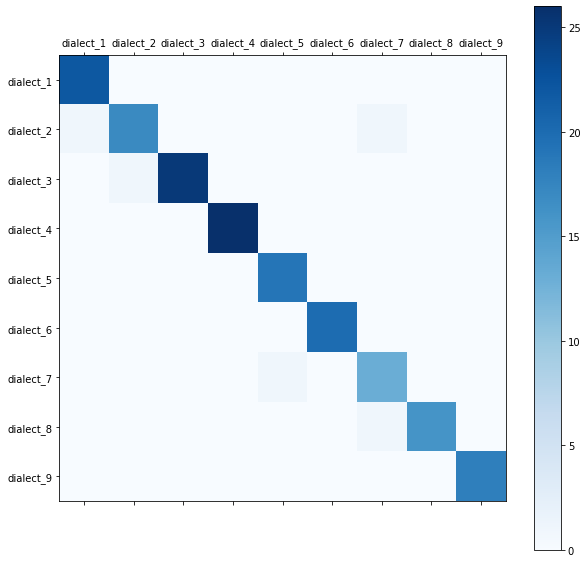

In [82]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
dialects = ['dialect_1', 'dialect_2', 'dialect_3', 'dialect_4', 'dialect_5', 'dialect_6', 'dialect_7', 'dialect_8', 'dialect_9']
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([""] + dialects)
ax.set_yticklabels([""] + dialects)


### Logistic Regression

In [83]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
lr.score(x_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9392265193370166

[[22  0  0  0  0  0  0  0  0]
 [ 0 14  3  0  1  0  1  0  0]
 [ 0  0 24  0  1  0  0  1  0]
 [ 0  0  0 26  0  0  0  0  0]
 [ 0  0  1  0 18  0  0  0  0]
 [ 0  0  0  1  0 19  0  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  1  0  0 16  0]
 [ 0  0  0  0  0  0  0  1 17]]


[Text(0, 0, ''),
 Text(0, 0, 'dialect_1'),
 Text(0, 0, 'dialect_2'),
 Text(0, 0, 'dialect_3'),
 Text(0, 0, 'dialect_4'),
 Text(0, 0, 'dialect_5'),
 Text(0, 0, 'dialect_6'),
 Text(0, 0, 'dialect_7'),
 Text(0, 0, 'dialect_8'),
 Text(0, 0, 'dialect_9')]

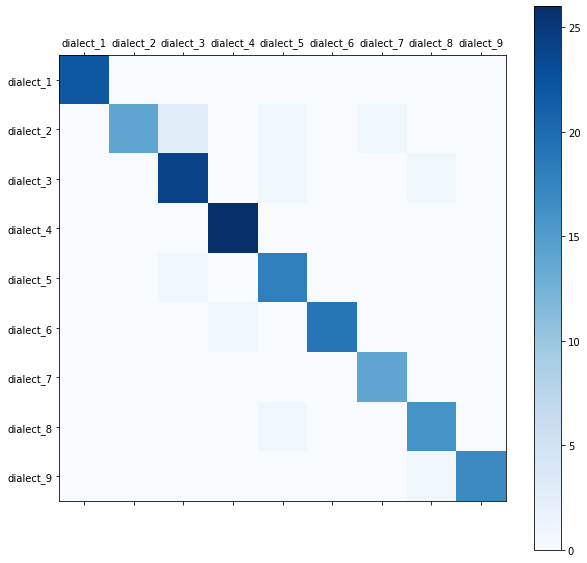

In [84]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
dialects = ['dialect_1', 'dialect_2', 'dialect_3', 'dialect_4', 'dialect_5', 'dialect_6', 'dialect_7', 'dialect_8', 'dialect_9']
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([""] + dialects)
ax.set_yticklabels([""] + dialects)


### K-Nearest Neighbours, k=5

In [85]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
knn.score(x_test, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.9723756906077348

[[22  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0]
 [ 0  1 25  0  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0]
 [ 0  0  0  0 19  0  0  0  0]
 [ 0  0  0  1  0 19  0  0  0]
 [ 0  0  0  0  1  0 13  0  0]
 [ 0  0  0  0  0  1  1 15  0]
 [ 0  0  0  0  0  0  0  0 18]]


[Text(0, 0, ''),
 Text(0, 0, 'dialect_1'),
 Text(0, 0, 'dialect_2'),
 Text(0, 0, 'dialect_3'),
 Text(0, 0, 'dialect_4'),
 Text(0, 0, 'dialect_5'),
 Text(0, 0, 'dialect_6'),
 Text(0, 0, 'dialect_7'),
 Text(0, 0, 'dialect_8'),
 Text(0, 0, 'dialect_9')]

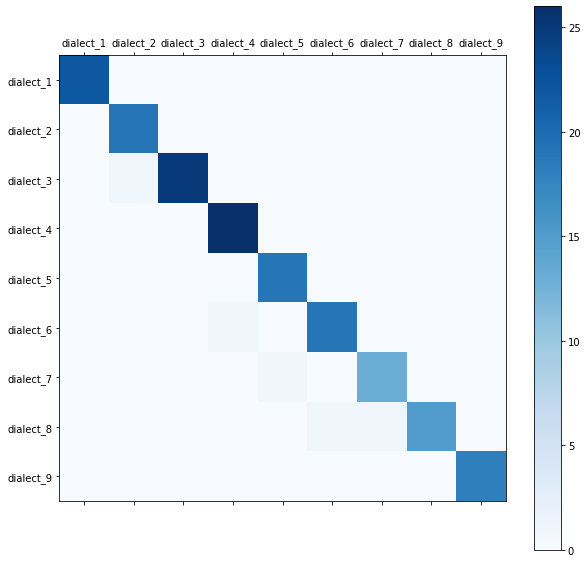

In [86]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
dialects = ['dialect_1', 'dialect_2', 'dialect_3', 'dialect_4', 'dialect_5', 'dialect_6', 'dialect_7', 'dialect_8', 'dialect_9']
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([""] + dialects)
ax.set_yticklabels([""] + dialects)


### K-Nearest Neighbours, k=3

In [87]:
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.988950276243094

[[22  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0]
 [ 0  1 25  0  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0]
 [ 0  0  0  0 19  0  0  0  0]
 [ 0  0  0  1  0 19  0  0  0]
 [ 0  0  0  0  1  0 13  0  0]
 [ 0  0  0  0  0  1  1 15  0]
 [ 0  0  0  0  0  0  0  0 18]]


[Text(0, 0, ''),
 Text(0, 0, 'dialect_1'),
 Text(0, 0, 'dialect_2'),
 Text(0, 0, 'dialect_3'),
 Text(0, 0, 'dialect_4'),
 Text(0, 0, 'dialect_5'),
 Text(0, 0, 'dialect_6'),
 Text(0, 0, 'dialect_7'),
 Text(0, 0, 'dialect_8'),
 Text(0, 0, 'dialect_9')]

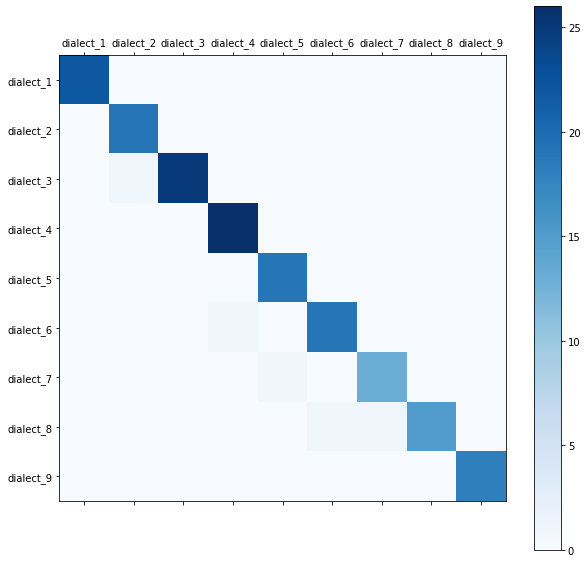

In [88]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
dialects = ['dialect_1', 'dialect_2', 'dialect_3', 'dialect_4', 'dialect_5', 'dialect_6', 'dialect_7', 'dialect_8', 'dialect_9']
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([""] + dialects)
ax.set_yticklabels([""] + dialects)
